## Autores

| Nome | nUSP |
| :--- | :--- |
| Guilherme de Abreu Barreto | 12543033 |
| Lucas Eduardo Gulka Pulcinelli | 12547336 |
| Vinicio Yusuke Hayashibara | 13642797 |

In [1]:
DEFAULT_DATABASE = "postgres"
CENSO_DATABASE = "censo2022"
USER = "postgres"
PASSWORD = "postgres"
HOST = "localhost"
PORT = 5432
URI = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}/"
FILES = {
    'states': {
        'filepath_or_buffer': 'datasets/BREstados.csv',
    },
    'cities': {
        'filepath_or_buffer': 'datasets/TabelaMunicipios.csv',
    },
    'households': {
        'filepath_or_buffer': 'datasets/tabela9923.csv',
    },
    'race': {
        'filepath_or_buffer': 'datasets/tabela9606.csv',
        'sep': ';',
        'header': None,
        'skiprows': 1,
    },
    'education': {
        'filepath_or_buffer': 'datasets/tabela10065.csv',
        'header': None,
        'skiprows': 1,
    },
}

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import re
from enum import Enum
from dataclasses import dataclass, fields
from math import sqrt
from sqlalchemy import (
    BigInteger,
    Float,
    Integer,
    Index,
    String,
    CheckConstraint as constraint,
    UniqueConstraint as unique,
    PrimaryKeyConstraint as pkc,
    ForeignKeyConstraint as fkc,
    ForeignKey as fk,
    JSON,
    cast,
    create_engine,
    insert,
    text,
    func,
    select,
)
from sqlalchemy.orm import (
    Mapped,
    Session,
    composite,
    declarative_base,
    declared_attr,
    relationship,
    sessionmaker,
    mapped_column as column,
    validates
)
from sqlalchemy.ext.hybrid import hybrid_method, hybrid_property
from sqlalchemy.sql.schema import CheckConstraint
from typing import Optional, Any

In [3]:
engine = create_engine(URI + DEFAULT_DATABASE, echo=True)

with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
    terminate_sql = text(f"""
        SELECT pg_terminate_backend(pid)
        FROM pg_stat_activity
        WHERE datname = '{CENSO_DATABASE}';
    """)
    try:
        conn.execute(terminate_sql)
    except ProgrammingError as e:
        print(f"Could not terminate connections (this is often normal): {e}")
    conn.execute(text(f"DROP DATABASE IF EXISTS {CENSO_DATABASE};"))
    conn.execute(text(f"CREATE DATABASE {CENSO_DATABASE};"))    
    

2025-09-20 18:00:33,538 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-09-20 18:00:33,539 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-20 18:00:33,541 INFO sqlalchemy.engine.Engine select current_schema()
2025-09-20 18:00:33,543 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-20 18:00:33,550 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-09-20 18:00:33,550 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-20 18:00:33,554 INFO sqlalchemy.engine.Engine BEGIN (implicit; DBAPI should not BEGIN due to autocommit mode)
2025-09-20 18:00:33,557 INFO sqlalchemy.engine.Engine 
        SELECT pg_terminate_backend(pid)
        FROM pg_stat_activity
        WHERE datname = 'censo2022';
    
2025-09-20 18:00:33,558 INFO sqlalchemy.engine.Engine [generated in 0.00422s] {}
2025-09-20 18:00:33,566 INFO sqlalchemy.engine.Engine DROP DATABASE IF EXISTS censo2022;
2025-09-20 18:00:33,567 INFO sqlalchemy.engine.Engine [generated in 0.00133s] {}
2025-09-20 18:0

In [4]:
def backref(back_populates: str) -> Mapped[Any]:
    return relationship(back_populates=back_populates)


def childOf(back_populates: str) -> Mapped[Any]:
    return relationship(
        back_populates=back_populates,
        cascade="all, delete-orphan",
    )

def digits(name:str) -> CheckConstraint:
    return constraint("id ~ '^[0-9]+$'", name=name)

In [5]:
class Households:
    def __init__(self, urban: int, rural: int) -> None:
        self.urban = urban
        self.rural = rural

    def __composite_values__(self) -> tuple[int, ...]:
        return (self.urban, self.rural)

    def __eq__(self, other):
        return isinstance(other, Households) and \
               other.urban == self.urban and \
               other.rural == self.rural

    def __ne__(self, other):
        return not self.__eq__(other)
        
    @hybrid_property
    def total(self):
        """Python-side property for total households."""
        return self.urban + self.rural

    @total.expression
    def total(cls):
        """SQL-side expression for querying total households."""
        return cls.urban + cls.rural

class Coordinate:
    """
    A geographic coordinate point with longitude (lon) and latitude (lat) components.
    """
    
    def __init__(self, longitude: float, latitude: float) -> None:
        self.longitude = longitude
        self.latitude = latitude

    @property
    def longitude(self) -> float:
        return self._longitude

    @longitude.setter
    def longitude(self, value: float) -> None:
        if not (-180 <= value <= 180):
            raise ValueError(
                f"Longitude must be between -180 and 180 degrees, got {value}"
            )
        self._longitude = value

    @property
    def latitude(self) -> float:
        return self._latitude

    @latitude.setter
    def latitude(self, value: float) -> None:
        if not (-90 <= value <= 90):
            raise ValueError(
                f"Latitude must be between -90 and 90 degrees, got {value}"
            )
        self._latitude = value

    def __composite_values__(self) -> tuple[float, ...]:
        return (self.longitude, self.latitude)

    def __eq__(self, other: "Coordinate") -> bool:
        return isinstance(other, Coordinate) and \
               other.longitude == self.longitude and \
               other.latitude == self.latitude
        
    def __ne__ (self, other: "Coordinate") -> bool:
        return not self.__eq__(other)

    @hybrid_method
    def distance(
        self,
        other: "Coordinate",
        metric: str = 'euclidean'
    ) -> float:
        """
        Calculate distance to another coordinate.
        
        Args:
            other: Coordinate instance
            metric: 'euclidean' or 'manhattan'
        
        Returns:
            Distance between coordinates
        """
        x = self.longitude - other.longitude
        y = self.latitude - other.latitude
        match metric:
            case 'euclidean':
                return sqrt(x**2 + y**2)
            case 'manhattan':
                return abs(x) + abs(y)
            case _:
                raise ValueError(
                    "Metric must be 'euclidean' or 'manhattan'"
                )

    @distance.expression
    def distance(
        cls,
        other_lon: float,
        other_lat: float,
        metric: str = 'euclidean'
    ):
        x = cls.longitude - other_lon
        y = cls.latitude - other_lat
        
        match metric:
            case 'euclidean':
                return func.sqrt(y * x + y * y)
            case 'manhattan':
                return func.abs(x) + func.abs(y)
            case _:
                raise ValueError(
                    "Metric must be 'euclidean' or 'manhattan'"
                )


class Biomes:
    default: dict[str, float] = {
        biome: 0.0 for biome in [
            'amazon_rainforest',
            'atlantic_forest',
            'caatinga',
            'cerrado',
            'pantanal',
            'pampas'
        ]
    }

    def __init__(self, *args) -> None:
        self.distribution = dict(zip(self.toList(), args))

    def __composite_values__(self) -> tuple[float, ...]:
        return tuple(getattr(self, biome) for biome in self.default.keys())

    def __eq__(self, other: "Biomes") -> bool:
        return self.__composite_values__() == other.__composite_values__()

    def __ne__(self, other: "Biomes") -> bool:
        return not self.__eq__(other)

    @property
    def distribution(self) -> dict[str, float]:
        return {biome: getattr(self, biome) for biome in self.default.keys()}


    @distribution.setter
    def distribution(self, values: dict[str, float]) -> None:
        merged_values = {**self.default, **values}

        # Validation
        invalid_keys = set(merged_values.keys()) - set(self.default.keys())
        if invalid_keys:
            raise ValueError(
                f"Invalid biome types: {invalid_keys}. Valid types are: {list(self.default.keys())}"
            )
        total = sum(merged_values.values())
        if not (99.9 <= total <= 100.1):
            raise ValueError(
                f"Invalid biome distribution, totalling {total:.1f}%"
            )
        self._distribution = merged_values

        for biome_type, value in merged_values.items():
            setattr(self, biome_type, value)

    @property
    def total(self) -> float:
        return sum(getattr(self, biome) for biome in self.default.keys())

    @classmethod
    def toList(cls) -> list[str]:
        return list(cls.default.keys())

In [6]:
Base = declarative_base()


class Region(Base):
    __tablename__: str = "regions"

    # Attributes
    id: Mapped[str] = column(
        String(1),
        digits("ck_region_id"),
        primary_key=True
    )
    name: Mapped[str] = column(unique=True)

    # Relationships
    states: Mapped[list["State"]] = childOf('region')

class Location(Base):
    __abstract__: bool = True


    longitude: Mapped[float]
    latitude: Mapped[float]    

    @validates("longitude")
    def validate_longitude(self, key, value: float) -> float:
        """Ensures longitude is within the valid range of -180 to 180."""
        if not (-180 <= value <= 180):
            raise ValueError(f"Longitude must be between -180 and 180, but got {value}")
        return value

    @validates("latitude")
    def validate_latitude(self, key, value: float) -> float:
        """Ensures latitude is within the valid range of -90 to 90."""
        if not (-90 <= value <= 90):
            raise ValueError(f"Latitude must be between -90 and 90, but got {value}")
        return value

    @hybrid_method
    def distance(
        self,
        other: "Location",
        metric: str = 'euclidean'
    ) -> float:
        """
        Calculate distance to another coordinate.
        
        Args:
            other: Coordinate instance
            metric: 'euclidean' or 'manhattan'
        
        Returns:
            Distance between coordinates
        """
        x = self.longitude - other.longitude
        y = self.latitude - other.latitude
        match metric:
            case 'euclidean':
                return sqrt(x**2 + y**2)
            case 'manhattan':
                return abs(x) + abs(y)
            case _:
                raise ValueError(
                    "Metric must be 'euclidean' or 'manhattan'"
                )

    @distance.expression
    def distance(
        cls,
        other_lon: float,
        other_lat: float,
        metric: str = 'euclidean'
    ):
        x = cls.longitude - other_lon
        y = cls.latitude - other_lat
        
        match metric:
            case 'euclidean':
                return func.sqrt(y * x + y * y)
            case 'manhattan':
                return func.abs(x) + func.abs(y)
            case _:
                raise ValueError(
                    "Metric must be 'euclidean' or 'manhattan'"
                )


class State(Location):
    __tablename__: str = "states"

    # Attributes
    id: Mapped[str] = column(String(1), digits("ck_state_id"))
    name: Mapped[str] = column(unique=True)
    uf: Mapped[str] = column(String(2), unique=True)
    area: Mapped[float]
    biome_distribution: Mapped[Biomes] = composite(
        *[column(biome, Float, default=0.0) for biome in Biomes.toList()]
    )

    # Foreign keys
    region_id: Mapped[str] = column(fk("regions.id"))

    # Relationships
    region: Mapped["Region"] = backref("states")
    cities: Mapped[list["City"]] = childOf("state")

    __table_args__: tuple[pkc, unique,] = (
        pkc("region_id", "id"),
        unique('longitude', 'latitude', name='uq_state_location'),
    )


class City(Location):
    __tablename__: str = "cities"

    # Attributes
    id: Mapped[str] = column(String(5), digits("ck_city_id"))
    name: Mapped[str]
    is_capital: Mapped[bool] = column(default=False, server_default='false')
    ddd: Mapped[str] = column(String(2), digits("ck_city_ddd"))
    households: Mapped[Households] = composite(
        column("urban", Integer),
        column("rural", Integer)
    )
    population_race: Mapped[dict | None] = column(JSON)
    population_education: Mapped[dict | None] = column(JSON)
    

    # Foreign keys
    timezone_name: Mapped[str] = column(fk("timezones.name"))
    region_id: Mapped[str]
    state_id: Mapped[str]

    # Relationships
    timezone: Mapped["Timezone"] = backref("cities")
    state: Mapped["State"] = backref("cities")

    @hybrid_property
    def ibge_code(self) -> str:
        """Python-side property to get the IBGE code."""
        return self.region_id + self.state_id + self.id

    @ibge_code.expression
    def ibge_code(cls):
        """SQL-side expression for querying."""
        return cast(
            func.concat(
                # Join to State to get the region ID
                cast(cls.region_id, String),
                cast(cls.state_id, String),
                cast(cls.id, String)
            ),
            BigInteger
        )

    __table_args__: tuple[pkc, fkc, unique, ] = (
        pkc("region_id", "state_id", "id"),
        fkc(
            ['region_id', 'state_id'],
            ['states.region_id', 'states.id'],
            name='fk_region_composite'
        ),
        unique("longitude", "latitude", name="uq_city_location"),
        Index(
            'state_capitals_index',
            'region_id', 'state_id',
            postgresql_where=text('is_capital'),
            unique=True,
        )
    )


class Timezone(Base):
    __tablename__: str = "timezones"

    # Attributes
    name: Mapped[str] = column(primary_key=True)
    utc_offset: Mapped[int]

    # Relationships
    cities: Mapped[list["City"]] = backref('timezone')

In [7]:
engine = create_engine(URI + CENSO_DATABASE, echo=True)
Session = sessionmaker(bind=engine)
Base.metadata.create_all(engine)

2025-09-20 18:00:33,855 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-09-20 18:00:33,855 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-20 18:00:33,857 INFO sqlalchemy.engine.Engine select current_schema()
2025-09-20 18:00:33,859 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-20 18:00:33,862 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-09-20 18:00:33,863 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-20 18:00:33,866 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-20 18:00:33,871 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [8]:
# 1. Region Data
regions_data = ["Norte", "Nordeste", "Sudeste", "Sul", "Centro-Oeste"]

# 2. Timezone Data
timezones_data = [
    ('America/Noronha', -2),
    ('America/Sao_Paulo', -3),
    ('America/Brasilia', -3),
    ('America/Recife', -3),
    ('America/Porto_Velho', -4),
    ('America/Manaus', -4),
    ('America/Rio_Branco', -5),
]

with Session() as session:
    # Populate the Regions table
    regions = [
        Region(id=str(idx), name=name) for idx, name in enumerate(regions_data, start=1)
    ]
    session.add_all(regions)

    # Populate the Timezones table
    timezones = [Timezone(name=name, utc_offset=offset) for name, offset in timezones_data]
    session.add_all(timezones)

    # Commit the changes to the database
    session.commit()

2025-09-20 18:00:33,987 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-20 18:00:33,989 INFO sqlalchemy.engine.Engine INSERT INTO regions (id, name) VALUES (%(id__0)s, %(name__0)s), (%(id__1)s, %(name__1)s), (%(id__2)s, %(name__2)s), (%(id__3)s, %(name__3)s), (%(id__4)s, %(name__4)s)
2025-09-20 18:00:33,991 INFO sqlalchemy.engine.Engine [generated in 0.00012s (insertmanyvalues) 1/1 (unordered)] {'name__0': 'Norte', 'id__0': '1', 'name__1': 'Nordeste', 'id__1': '2', 'name__2': 'Sudeste', 'id__2': '3', 'name__3': 'Sul', 'id__3': '4', 'name__4': 'Centro-Oeste', 'id__4': '5'}
2025-09-20 18:00:33,997 INFO sqlalchemy.engine.Engine INSERT INTO timezones (name, utc_offset) VALUES (%(name__0)s, %(utc_offset__0)s), (%(name__1)s, %(utc_offset__1)s), (%(name__2)s, %(utc_offset__2)s), (%(name__3)s, %(utc_offset__3)s), (%(name__4)s, %(utc_offset__4)s), (%(name__5)s, %(utc_offset__5)s), (%(name__6)s, %(utc_offset__6)s)
2025-09-20 18:00:33,998 INFO sqlalchemy.engine.Engine [generated in 0.00016

In [9]:
df = pd.read_csv(**FILES['states'])
df.fillna(0.0, inplace=True)
BIOME_COLUMN_MAPPING = {
    'Amazônia': 'amazon_rainforest',
    'Mata Atlântica': 'atlantic_forest',
    'Caatinga': 'caatinga',
    'Cerrado': 'cerrado',
    'Pantanal': 'pantanal',
    'Pampa': 'pampas'
}
csv_biome_cols = df.columns[8:].tolist()

states_to_insert = []
for _, row in df.iterrows():
    code_str = str(row['codigouf'])
    state_data = {
        'region_id': code_str[0],
        'id': code_str[1],
        'uf': row['uf'],
        'name': row['estado'],
        'longitude': row['long'],
        'latitude': row['lat'],
        'area': row['Area']
    }

    for csv_col in csv_biome_cols:
        model_attr = BIOME_COLUMN_MAPPING.get(csv_col)
        state_data[model_attr] = row[csv_col]

    states_to_insert.append(state_data)


with Session() as session:
    session.bulk_insert_mappings(State, states_to_insert)
    session.commit()

2025-09-20 18:00:34,020 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-20 18:00:34,023 INFO sqlalchemy.engine.Engine INSERT INTO states (id, name, uf, area, amazon_rainforest, atlantic_forest, caatinga, cerrado, pantanal, pampas, region_id, longitude, latitude) VALUES (%(id__0)s, %(name__0)s, %(uf__0)s, %(area__0)s, %(amazon_rainforest__0)s, %(atlantic_forest__0)s, ... 5907 characters truncated ... ado__26)s, %(pantanal__26)s, %(pampas__26)s, %(region_id__26)s, %(longitude__26)s, %(latitude__26)s)
2025-09-20 18:00:34,024 INFO sqlalchemy.engine.Engine [generated in 0.00029s (insertmanyvalues) 1/1 (unordered)] {'amazon_rainforest__0': 99.0, 'id__0': '1', 'pampas__0': 0.0, 'atlantic_forest__0': 0.0, 'longitude__0': -63.34, 'cerrado__0': 1.0, 'uf__0': 'RO', 'region_id__0': '1', 'latitude__0': -10.83, 'caatinga__0': 0.0, 'pantanal__0': 0.0, 'name__0': 'Rondônia', 'area__0': 237754.171, 'amazon_rainforest__1': 100.0, 'id__1': '2', 'pampas__1': 0.0, 'atlantic_forest__1': 0.0, 'longitu

In [10]:
def generate_city_uf_key(name: str, uf: str) -> str:
    """Creates a standardized, URL-friendly key from a city name and UF."""
    # Normalize (remove accents), convert to lowercase, replace spaces with hyphens
    normalized_name = ''.join(c for c in unicodedata.normalize('NFD', name) 
                              if unicodedata.category(c) != 'Mn')
    return f"{normalized_name.lower().replace(' ', '-')}_{uf.lower()}"

def parse_municipio(municipio_str: str) -> tuple[str, str] | None:
    """Parses a string like 'São Carlos (SP)' into ('São Carlos', 'SP')."""
    match = re.match(r'^(.*?)\s*\((.*?)\)$', municipio_str)
    if match:
        return match.group(1).strip(), match.group(2).strip()
    return None

def create_race_json(row: pd.Series) -> dict:
    """Builds the population_race JSON object from a DataFrame row."""
    return {
        'white': {'male': row[4], 'female': row[5]},
        'black': {'male': row[7], 'female': row[8]},
        'yellow': {'male': row[9], 'female': row[10]},
        'pardo': {'male': row[11], 'female': row[12]},
        'indigenous': {'male': row[13], 'female': row[14]},
    }

def create_education_json(row: pd.Series) -> dict:
    """Builds the population_education JSON object from a DataFrame row."""
    return {
        'education': {'male': row[3], 'female': row[4]},
        'arts_and_humanities': {'male': row[5], 'female': row[6]},
        'social_sciences': {'male': row[7], 'female': row[8]},
        'administration': {'male': row[9], 'female': row[10]},
        'natural_sciences': {'male': row[11], 'female': row[12]},
        'information_tecnology': {'male': row[13], 'female': row[14]},
        'engineering': {'male': row[15], 'female': row[16]},
        'agriculture': {'male': row[17], 'female': row[18]},
        'health': {'male': row[19], 'female': row[20]},
        'services': {'male': row[21], 'female': row[22]},
        'unknown': {'male': row[23], 'female': row[24]},
    }

with Session() as session:
    # Query for the necessary columns from the State table
    stmt = select(State.region_id, State.id, State.uf)
    results = session.execute(stmt).all()
    
    # Construct the dictionary by combining region_id and id for the key
    state_map = {res.region_id + res.id: res.uf for res in results}

    # === PHASE 1: INITIAL LOAD FROM MAIN CSV ===
    print("Phase 1: Loading initial city data...")
    df_cities = pd.read_csv(**FILES['cities'])
    df_cities.fillna({'ddd': 0}, inplace=True) # Handle potential NaN in ddd

    cities_to_insert = []
    for _, row in df_cities.iterrows():
        ibge_code = str(row['codigo_ibge'])
        state_code = ibge_code[:2]
        
        # Create the city_uf_key for future merges
        uf = state_map.get(state_code)
        
        city_data = {
            'region_id': ibge_code[0],
            'state_id': ibge_code[1],
            'id': ibge_code[2:],
            'name': row['nome'],
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'ddd': str(int(row['ddd'])),
            'is_capital': bool(row['capital']),
            'timezone_name': row['fuso_horario'],
            # Add city_uf_key temporarily for in-memory joins
            '_city_uf_key': generate_city_uf_key(row['nome'], uf)
        }
        cities_to_insert.append(city_data)

    # Perform the initial bulk insert
    session.bulk_insert_mappings(City, cities_to_insert)
    session.commit()
    print(f"✅ Inserted {len(cities_to_insert)} base city records.")

    # Create a DataFrame from the inserted data for easy merging
    df_inserted = pd.DataFrame(cities_to_insert)

    # === PHASE 2: ENRICHMENT ===
    
    # --- Households Data ---
    print("\nPhase 2.1: Enriching with households data...")
    df_house = pd.read_csv(**FILES['households'])
    df_house.dropna(subset=['Município'], inplace=True)
    
    # Create the merge key
    parsed_data = df_house['Município'].apply(parse_municipio)
    df_house[['name', 'uf']] = pd.DataFrame(parsed_data.tolist(), index=df_house.index)
    df_house['_city_uf_key'] = df_house.apply(lambda row: generate_city_uf_key(row['name'], row['uf']), axis=1)

    # Merge to get the primary keys
    df_merged_house = pd.merge(df_inserted, df_house, on='_city_uf_key')
    
    households_to_update = df_merged_house[[
        'region_id', 'state_id', 'id', 'Urbana', 'Rural'
    ]].rename(columns={'Urbana': 'urban', 'Rural': 'rural'}).to_dict('records')

    session.bulk_update_mappings(City, households_to_update)
    session.commit()
    print(f"✅ Updated {len(households_to_update)} records with household data.")

    # --- Race Data ---
    print("\nPhase 2.2: Enriching with population race data...")
    df_race = pd.read_csv(**FILES['race'])
    df_race.dropna(subset=[0], inplace=True)

    parsed_data_race = df_race[0].apply(parse_municipio)
    df_race[['name', 'uf']] = pd.DataFrame(parsed_data_race.tolist(), index=df_race.index)
    df_race['_city_uf_key'] = df_race.apply(lambda row: generate_city_uf_key(row['name'], row['uf']), axis=1)
    df_race['population_race'] = df_race.apply(create_race_json, axis=1)

    df_merged_race = pd.merge(df_inserted, df_race, on='_city_uf_key')

    race_to_update = df_merged_race[[
        'region_id', 'state_id', 'id', 'population_race'
    ]].to_dict('records')

    session.bulk_update_mappings(City, race_to_update)
    session.commit()
    print(f"✅ Updated {len(race_to_update)} records with race data.")
    
    # --- Education Data ---
    print("\nPhase 2.3: Enriching with population education data...")
    df_edu = pd.read_csv(**FILES['education'])
    df_edu.dropna(subset=[0], inplace=True)

    parsed_data_edu = df_edu[0].apply(parse_municipio)
    df_edu[['name', 'uf']] = pd.DataFrame(parsed_data_edu.tolist(), index=df_edu.index)
    df_edu['_city_uf_key'] = df_edu.apply(lambda row: generate_city_uf_key(row['name'], row['uf']), axis=1)
    df_edu['population_education'] = df_edu.apply(create_education_json, axis=1)

    df_merged_edu = pd.merge(df_inserted, df_edu, on='_city_uf_key')

    edu_to_update = df_merged_edu[[
        'region_id', 'state_id', 'id', 'population_education'
    ]].to_dict('records')

    session.bulk_update_mappings(City, edu_to_update)
    session.commit()
    print(f"✅ Updated {len(edu_to_update)} records with education data.")
    
    print("\n🎉 All city data loaded and merged successfully!")



2025-09-20 18:00:34,072 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-20 18:00:34,075 INFO sqlalchemy.engine.Engine SELECT states.region_id, states.id, states.uf 
FROM states
2025-09-20 18:00:34,077 INFO sqlalchemy.engine.Engine [generated in 0.00255s] {}
Phase 1: Loading initial city data...
2025-09-20 18:00:34,743 INFO sqlalchemy.engine.Engine INSERT INTO cities (id, name, is_capital, ddd, timezone_name, region_id, state_id, longitude, latitude) VALUES (%(id__0)s, %(name__0)s, %(is_capital__0)s, %(ddd__0)s, %(timezone_name__0)s, %(region_id__0)s, %(state_id__0)s, %(longitude__0)s, %(latitu ... 165769 characters truncated ... (timezone_name__999)s, %(region_id__999)s, %(state_id__999)s, %(longitude__999)s, %(latitude__999)s)
2025-09-20 18:00:34,744 INFO sqlalchemy.engine.Engine [generated in 0.03434s (insertmanyvalues) 1/6 (unordered)] {'id__0': '00050', 'longitude__0': -49.4412, 'is_capital__0': False, 'ddd__0': '62', 'timezone_name__0': 'America/Sao_Paulo', 'state_id__0': '

In [11]:
def find_nearby_cities(
    session: Session,
    city_name: str,
    uf_code: str,
    count: int,
    distance_metric: str
) -> list[City] | None:
    """
    Finds a specified number of cities closest to a target city.

    Args:
        session: The SQLAlchemy session for database queries.
        city_name: The name of the target city (e.g., 'São Carlos').
        uf_code: The two-letter state code of the target city (e.g., 'SP').
        count: The number of nearby cities to return.
        distance_metric: The distance metric ('manhattan' or 'euclidean').

    Returns:
        A list of City ORM objects, or None if the target city is not found.
    """
    # Step 1: Find the target city's coordinates and IBGE code
    print(f"Finding coordinates for {city_name}, {uf_code}...")
    stmt = select(City.longitude, City.latitude).join_from(City, State).where(
        City.name == city_name,
        State.uf == uf_code
    )
    target = session.execute(stmt).first()
    
    if not target:
        print(f"Error: {city_name}, {uf_code} not found in the database.")
        return None
        
    target_lon = target.longitude
    target_lat = target.latitude
    print(f"Found {city_name} at ({target_lat:.4f}, {target_lon:.4f})")

    # Step 2: Query for the closest cities
    print(f"Querying for the top {count + 1} closest cities using {distance_metric} distance...")
    
    # CORRECTED: Call the hybrid method on the City.location attribute
    distance_expr = City.distance(
        target_lon, target_lat, metric=distance_metric
    ).label("distance")
    
    stmt = select(City).order_by(distance_expr).limit(count + 1)
    
    all_results = session.execute(stmt).scalars().all()
    closest_cities = all_results[1:]
    
    print(f"Found {len(closest_cities)} nearby cities:")
    for city in closest_cities:
        print(f"- {city.name}, {city.state.uf}")
        
    return closest_cities

def plot_demographic_distributions(
    cities: list[City],
    language: str = 'en'
) -> None:
    """
    Processes and plots demographic data from a list of City objects, with
    support for English ('en') and Portuguese ('pt') languages.
    """
    if not cities:
        print("No cities provided to plot. Aborting.")
        return

    # --- Translation Dictionary ---
    TRANSLATIONS = {
        'pt': {
            'male': 'Homens', 'female': 'Mulheres', 'gender': 'Gênero',
            'race_cats': {
                'White': 'Branca', 'Black': 'Preta', 'Yellow': 'Amarela',
                'Pardo': 'Parda', 'Indigenous': 'Indígena'
            },
            'edu_cats': {
                'Education': 'Educação', 'Arts And Humanities': 'Artes e Humanidades',
                'Social Sciences': 'Ciências Sociais', 'Administration': 'Administração',
                'Natural Sciences': 'Ciências Naturais', 'Information Tecnology': 'Tecnologia da Informação',
                'Engineering': 'Engenharia', 'Agriculture': 'Agricultura',
                'Health': 'Saúde', 'Services': 'Serviços', 'Unknown': 'Não especificado'
            },
            'plot1_title': 'População por Raça e Gênero ({count} Cidades Próximas)',
            'plot1_xlabel': 'Categoria de Raça',
            'plot2_title': 'População por Área de Formação e Gênero ({count} Cidades Próximas)',
            'plot2_xlabel': 'Área de Formação',
            'plot3_title': 'Distribuição Total de Homens vs. Mulheres ({count} Cidades Próximas)',
            'total_pop': 'População Total', 'group': 'Grupo',
            'group_race': 'Raça', 'group_edu': 'Formação'
        }
    }
    # Fallback to English if language is not 'pt'
    lang_map = TRANSLATIONS.get(language, {})

    # --- Data Processing ---
    race_data = []
    edu_data = []
    for city in cities:
        for cat, genders in city.population_race.items():
            en_cat = cat.replace('_', ' ').title()
            race_data.append({
                "race": lang_map.get('race_cats', {}).get(en_cat, en_cat),
                "male": genders.get('male', 0),
                "female": genders.get('female', 0)
            })
        for cat, genders in city.population_education.items():
            en_cat = cat.replace('_', ' ').title()
            edu_data.append({
                "education_field": lang_map.get('edu_cats', {}).get(en_cat, en_cat),
                "male": genders.get('male', 0),
                "female": genders.get('female', 0)
            })

    df_race = pd.DataFrame(race_data)
    df_edu = pd.DataFrame(edu_data)
    race_summary = df_race.groupby('race')[['male', 'female']].sum()
    edu_summary = df_edu.groupby('education_field')[['male', 'female']].sum()
    
    # Rename columns for legend translation
    if language == 'pt':
        race_summary.rename(columns={'male': lang_map['male'], 'female': lang_map['female']}, inplace=True)
        edu_summary.rename(columns={'male': lang_map['male'], 'female': lang_map['female']}, inplace=True)

    # --- Plot Generation ---
    print("Gerando gráficos demográficos...")
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(3, 1, figsize=(12, 22))
    
    # Plot 1: Race
    race_summary.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
    axes[0].set_title(lang_map.get('plot1_title', 'Pop. by Race').format(count=len(cities)), fontsize=16)
    axes[0].set_xlabel(lang_map.get('plot1_xlabel', 'Race Category'), fontsize=12)
    axes[0].set_ylabel(lang_map.get('total_pop', 'Total Population'), fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Education
    edu_summary.plot(kind='bar', stacked=True, ax=axes[1], colormap='plasma')
    axes[1].set_title(lang_map.get('plot2_title', 'Pop. by Education').format(count=len(cities)), fontsize=16)
    axes[1].set_xlabel(lang_map.get('plot2_xlabel', 'Education Field'), fontsize=12)
    axes[1].set_ylabel(lang_map.get('total_pop', 'Total Population'), fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Totals
    df_totals = pd.DataFrame({
        lang_map.get('group', 'Group'): [lang_map.get('group_race', 'Race')] * 2 + [lang_map.get('group_edu', 'Education')] * 2,
        lang_map.get('gender', 'Gender'): [lang_map.get('male', 'Male'), lang_map.get('female', 'Female')] * 2,
        lang_map.get('total_pop', 'Total Population'): [df_race['male'].sum(), df_race['female'].sum(), df_edu['male'].sum(), df_edu['female'].sum()]
    })
    sns.barplot(data=df_totals, x=lang_map.get('group', 'Group'), y=lang_map.get('total_pop', 'Total Population'), 
                hue=lang_map.get('gender', 'Gender'), ax=axes[2], palette='muted')
    axes[2].set_title(lang_map.get('plot3_title', 'Total Gender Dist.').format(count=len(cities)), fontsize=16)
    axes[2].set_xlabel('')
    axes[2].set_ylabel(lang_map.get('total_pop', 'Total Population'), fontsize=12)
    
    plt.tight_layout()
    plt.show()

Finding coordinates for São Carlos, SP...
2025-09-20 18:00:43,292 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-20 18:00:43,297 INFO sqlalchemy.engine.Engine SELECT cities.longitude, cities.latitude 
FROM cities JOIN states ON states.region_id = cities.region_id AND states.id = cities.state_id 
WHERE cities.name = %(name_1)s AND states.uf = %(uf_1)s
2025-09-20 18:00:43,298 INFO sqlalchemy.engine.Engine [generated in 0.00158s] {'name_1': 'São Carlos', 'uf_1': 'SP'}
Found São Carlos at (-22.0174, -47.8860)
Querying for the top 11 closest cities using manhattan distance...
2025-09-20 18:00:43,309 INFO sqlalchemy.engine.Engine SELECT cities.id, cities.name, cities.is_capital, cities.ddd, cities.urban, cities.rural, cities.population_race, cities.population_education, cities.timezone_name, cities.region_id, cities.state_id, cities.longitude, cities.latitude 
FROM cities ORDER BY abs(cities.longitude - %(longitude_1)s) + abs(cities.latitude - %(latitude_1)s) 
 LIMIT %(param_1)s
2025

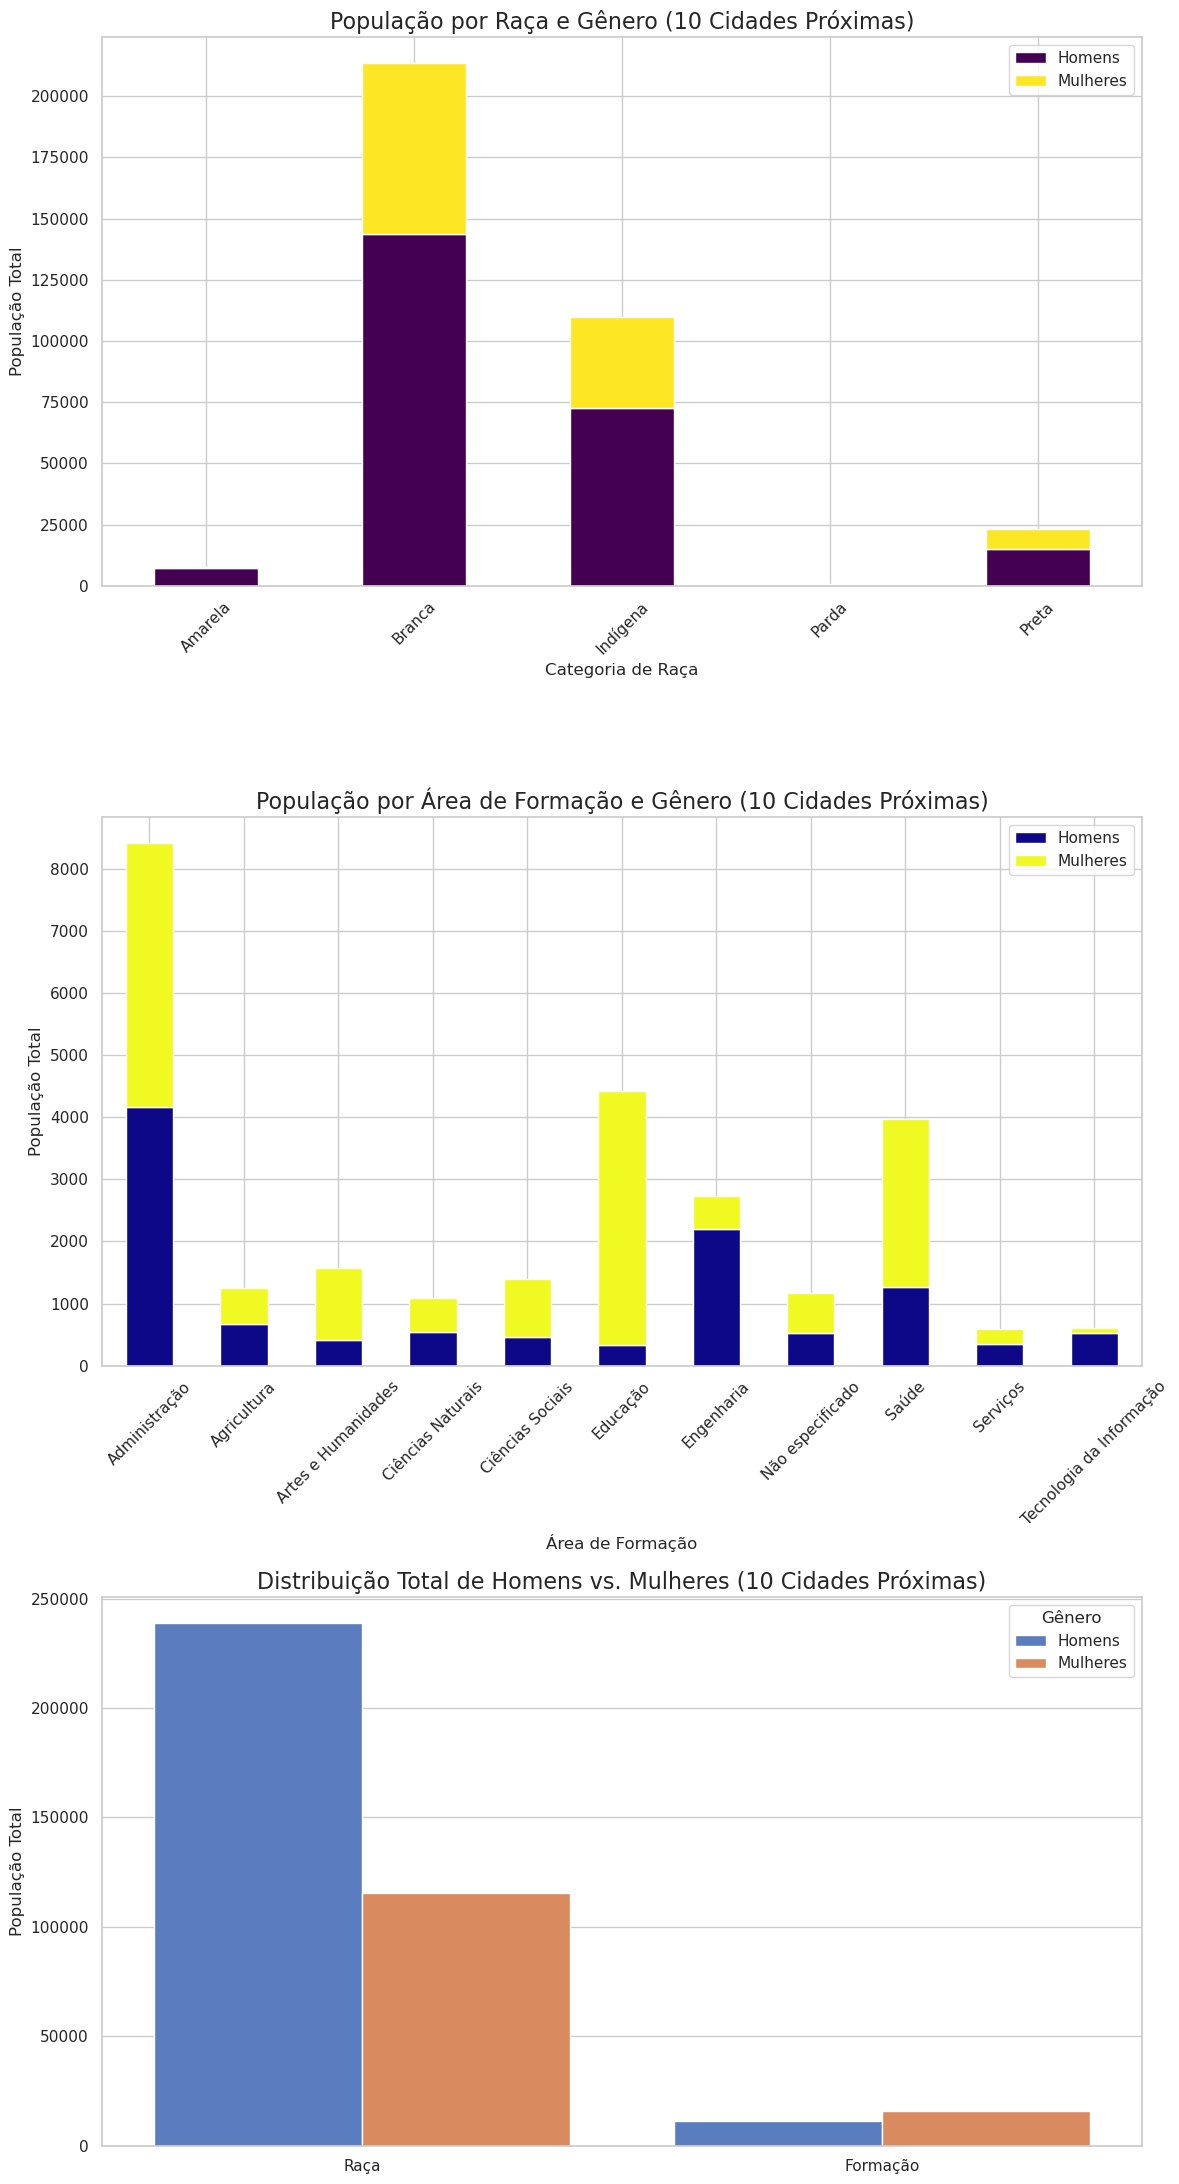

2025-09-20 18:00:44,659 INFO sqlalchemy.engine.Engine ROLLBACK


In [12]:
with Session() as session:
    cities = find_nearby_cities(session, 'São Carlos', 'SP', 10, 'manhattan')
    plot_demographic_distributions(cities, 'pt')

### 